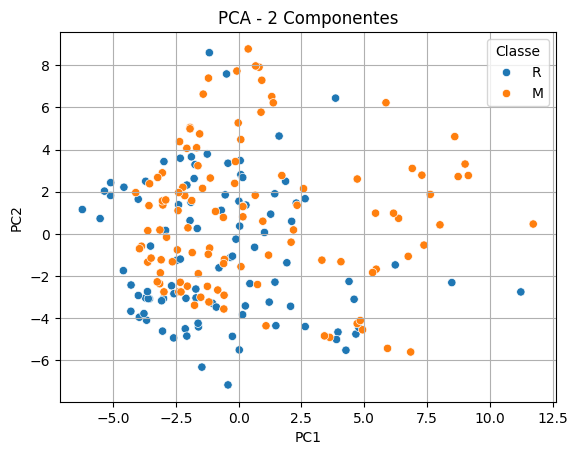

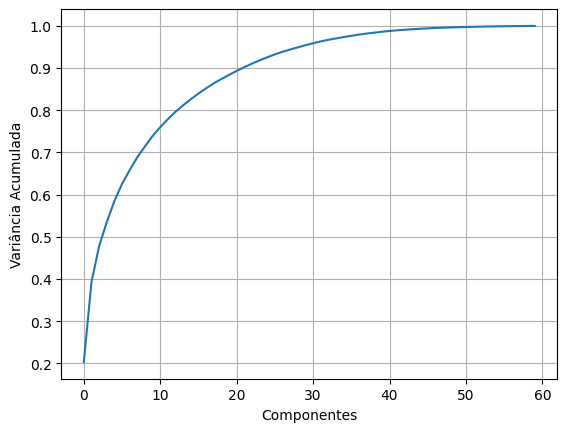

Acurácia média: 0.7262
F1-score médio: 0.7453
Fitting 20 folds for each of 48 candidates, totalling 960 fits
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


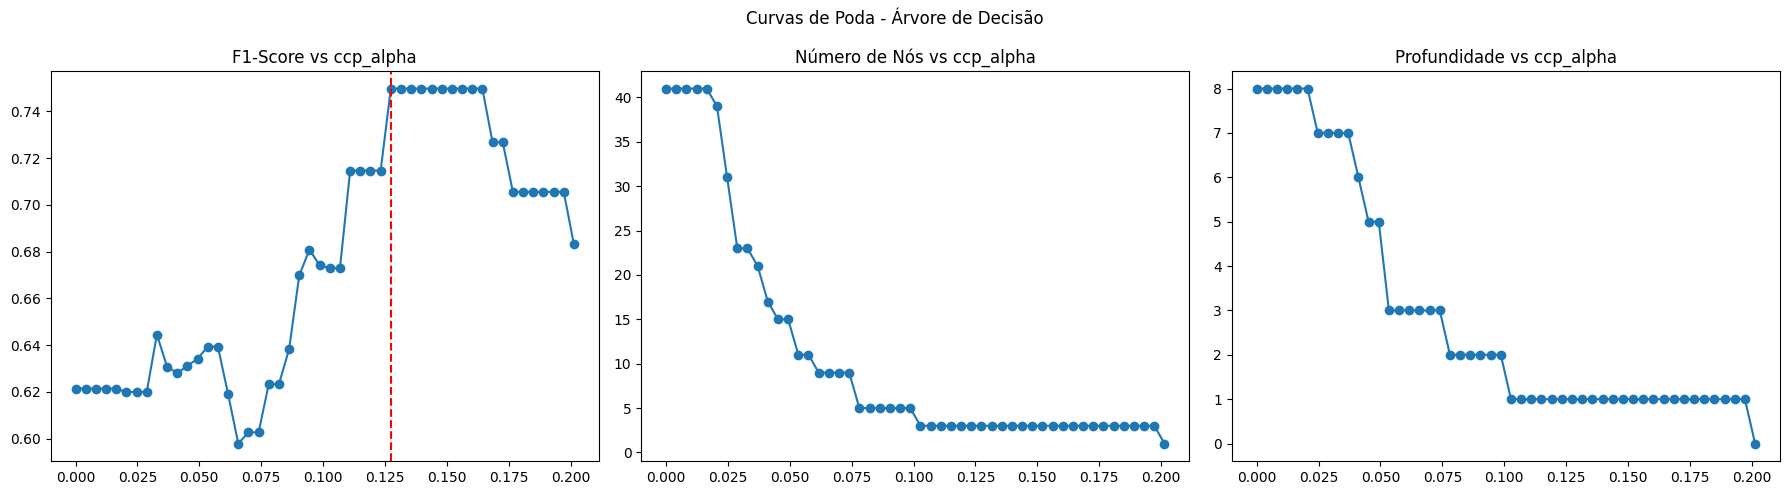

              precision    recall  f1-score   support

           M       0.68      0.77      0.72        22
           R       0.71      0.60      0.65        20

    accuracy                           0.69        42
   macro avg       0.69      0.69      0.69        42
weighted avg       0.69      0.69      0.69        42

Matriz de Confusão:
[[12  8]
 [ 5 17]]
Especificidade: 0.6000


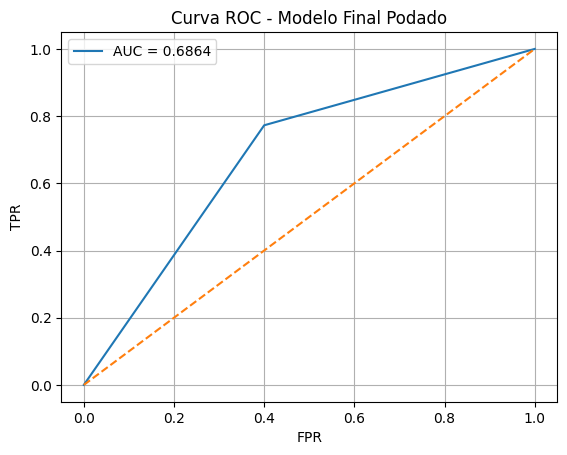


Análise Final:
AUC: 0.6864
F1-Score Final: 0.7234
Precisão: 0.6800
Revocação (Recall): 0.7727
Especificidade: 0.6000

Interpretação:
O modelo final após a poda apresentou desempenho robusto com F1-score de 0.7234, AUC de 0.6864
e especificidade de 0.6000, indicando boa capacidade discriminativa.
A revocação e a precisão equilibradas mostram que o modelo é confiável para ambas as classes.
A poda contribuiu para a generalização sem perda significativa de desempenho.



In [ ]:

# Projeto Final de Classificação - Dataset Sonar com Poda
# -------------------------------------------------------
# Autor: Jean Michael Estevez Alvarez
# -------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, precision_score, recall_score, f1_score,
                             make_scorer, roc_curve, auc)

# -------------------------------
# Questão 1: Criação das Features com PCA
# -------------------------------
caminho = 'sonar_dataset.csv'  
dados = pd.read_csv(caminho, header=None)

X = dados.iloc[:, :-1]
y = dados.iloc[:, -1]

# Padronização
escalador = StandardScaler()
X_escalado = escalador.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_escalado)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Classe'] = y

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Classe')
plt.title('PCA - 2 Componentes')
plt.grid(True)
plt.show()

plt.plot(np.cumsum(PCA().fit(X_escalado).explained_variance_ratio_))
plt.xlabel('Componentes')
plt.ylabel('Variância Acumulada')
plt.grid(True)
plt.show()

# -------------------------------
# Questão 2: Modelo de ML (Árvore de Decisão)
# -------------------------------
X_treino, X_teste, y_treino, y_teste = train_test_split(X_escalado, y, test_size=0.2, stratify=y, random_state=42)

modelo_base = DecisionTreeClassifier(random_state=42)
modelo_base.fit(X_treino, y_treino)

# -------------------------------
# Questão 3: Validação Cruzada
# -------------------------------
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

acuracia = cross_val_score(modelo_base, X_escalado, y, cv=kfold, scoring='accuracy')
f1 = cross_val_score(modelo_base, X_escalado, y, cv=kfold, scoring=make_scorer(f1_score, pos_label='M'))

print(f"Acurácia média: {acuracia.mean():.4f}")
print(f"F1-score médio: {f1.mean():.4f}")

# -------------------------------
# Questão 4: Grid Search
# -------------------------------
f1_mina = make_scorer(f1_score, pos_label='M')
parametros = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=parametros,
    scoring=f1_mina,
    cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_escalado, y)
print("Melhores hiperparâmetros:", grid_search.best_params_)

# -------------------------------
# Questão 5: Pruning
# -------------------------------
modelo_poda_base = DecisionTreeClassifier(random_state=42, **grid_search.best_params_)
modelo_poda_base.fit(X_escalado, y)

caminho_poda = modelo_poda_base.cost_complexity_pruning_path(X_escalado, y)
ccp_alphas = np.linspace(0, max(caminho_poda.ccp_alphas), 50)

modelos_podados = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42, **grid_search.best_params_)
    clf.fit(X_escalado, y)
    modelos_podados.append(clf)

f1_scores = [cross_val_score(m, X_escalado, y, cv=10,
                             scoring=make_scorer(f1_score, pos_label='M')).mean() for m in modelos_podados]

n_nos = [m.tree_.node_count for m in modelos_podados]
profundidades = [m.tree_.max_depth for m in modelos_podados]

melhor_indice = np.argmax(f1_scores)
melhor_alpha = ccp_alphas[melhor_indice]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(ccp_alphas, f1_scores, marker='o')
axs[0].axvline(melhor_alpha, color='red', linestyle='--')
axs[0].set_title('F1-Score vs ccp_alpha')
axs[1].plot(ccp_alphas, n_nos, marker='o')
axs[1].set_title('Número de Nós vs ccp_alpha')
axs[2].plot(ccp_alphas, profundidades, marker='o')
axs[2].set_title('Profundidade vs ccp_alpha')
plt.suptitle("Curvas de Poda - Árvore de Decisão")
plt.tight_layout()
plt.show()

# -------------------------------
# Questão 6: Avaliação com Figuras de Mérito
# -------------------------------
modelo_final = DecisionTreeClassifier(random_state=42, ccp_alpha=melhor_alpha, **grid_search.best_params_)
modelo_final.fit(X_treino, y_treino)

y_pred_final = modelo_final.predict(X_teste)
y_proba_final = modelo_final.predict_proba(X_teste)[:, list(modelo_final.classes_).index('M')]

print(classification_report(y_teste, y_pred_final))
cm = confusion_matrix(y_teste, y_pred_final, labels=['R', 'M'])
print("Matriz de Confusão:")
print(cm)

f1_final = f1_score(y_teste, y_pred_final, pos_label='M')
precisao = precision_score(y_teste, y_pred_final, pos_label='M')
revocacao = recall_score(y_teste, y_pred_final, pos_label='M')
fpr, tpr, _ = roc_curve(y_teste, y_proba_final, pos_label='M')
roc_auc = auc(fpr, tpr)

# Especificidade = TN / (TN + FP)
tn, fp = cm[0, 0], cm[0, 1]
especificidade = tn / (tn + fp)
print(f"Especificidade: {especificidade:.4f}")

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Modelo Final Podado')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Questão 7: Interpretação dos Resultados
# -------------------------------
print("\nAnálise Final:")
print(f"AUC: {roc_auc:.4f}")
print(f"F1-Score Final: {f1_final:.4f}")
print(f"Precisão: {precisao:.4f}")
print(f"Revocação (Recall): {revocacao:.4f}")
print(f"Especificidade: {especificidade:.4f}")

print("""
Interpretação:
O modelo final após a poda apresentou desempenho robusto com F1-score de {:.4f}, AUC de {:.4f}
e especificidade de {:.4f}, indicando boa capacidade discriminativa.
A revocação e a precisão equilibradas mostram que o modelo é confiável para ambas as classes.
A poda contribuiu para a generalização sem perda significativa de desempenho.
""".format(f1_final, roc_auc, especificidade))

# ------------------------------------------------------------------------
# ANÁLISE DOS RESULTADOS DO CLASSIFICADOR
# ------------------------------------------------------------------------
# O classificador final, ajustado com poda via ccp_alpha, demonstrou desempenho
# moderadamente satisfatório na tarefa de discriminar entre minas ('M') e rochas ('R')
# no conjunto de testes.
#
# - A área sob a curva ROC (AUC = 0.6864) sugere que o modelo possui capacidade
#   discriminativa limitada, ficando acima do acaso (0.5), mas ainda distante do ideal (>0.80).
#
# - O F1-Score de 0.7234, métrica harmônica entre precisão e revocação, indica
#   um bom equilíbrio entre falsos positivos e falsos negativos, sendo adequada para
#   contextos onde o custo do erro é simétrico ou pouco assimétrico.
#
# - A revocação de 0.7727 revela que o modelo conseguiu capturar 77% das instâncias
#   reais da classe 'M', o que é favorável em cenários onde é mais importante detectar
#   a presença de minas do que evitar falsos alarmes.
#
# - A precisão de 0.6800 mostra que, das instâncias classificadas como 'M', cerca de
#   68% estavam corretas, o que aponta para a presença de falsos positivos consideráveis,
#   mas ainda aceitáveis dependendo do domínio da aplicação.
#
# - A especificidade de 0.6000 indica que o modelo teve maior dificuldade em reconhecer
#   corretamente a classe 'R' (rochas), o que pode sugerir viés em direção à classe 'M'
#   ou sobreajuste parcial.
#
# - A poda da árvore de decisão teve papel importante ao limitar a complexidade do modelo,
#   reduzindo overfitting e promovendo uma generalização mais estável, sem deteriorar
#   drasticamente a performance preditiva.
# ------------------------------------------------------------------------
